In [1]:
import sys
# import from dirs below
sys.path.insert(0, "..")
sys.path.insert(0, "../src")
sys.path.insert(0, "../src/new_generation")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from typing import List, Tuple
import random

from copy import deepcopy
import networkx as nx

import line_generation as lg
from Genotype import Genotype
from fitness import fitness
from params import N, SEED, N_IN_POPULATION
from graph_generation import generate_city_graph
from SimultionEngine import SimulationEngine

from main import create_initial_population, n_best_survive, new_generation_replace_random_line

from new_generation.Mutators import LineMutator, GenotypeMutator
from new_generation.SpecimenCrossers import GenotypeCrosser

In [4]:
from SimultionEngine import SimulationEngine

In [5]:
G, best_paths = generate_city_graph(N)

line_mutator = LineMutator(best_paths)
genotype_mutator = GenotypeMutator(G, best_paths)

genotype_crosser = GenotypeCrosser(best_paths)

## Symulacja

Population 0, fitness function: -220.00890129702555
lines with X stops: Counter({10: 200})


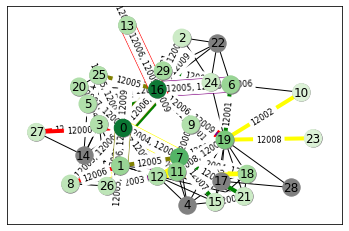

1 lines with X stops: Counter({10: 200})
2 lines with X stops: Counter({10: 200})
3 lines with X stops: Counter({10: 40})


TypeError: Can't instantiate abstract class LineListLinearizer with abstract methods __delitem__, insert

In [12]:
random.seed(SEED)

CHANCE_MERGE = 0.1

CHANCE_ROT_RIGHT = 0.1
CHANCE_ROT_CYCLE = 0.1
CHANCE_INVERT = 0.1

CHANCE_ERASE_LINE = 0.1
CHANCE_CREATE_LINE = 0.1
CHANCE_SPLIT = 0.1
CHANCE_MERGE = 0.1
CHANCE_CYCLE = 0.1


def new_generation(
    population_with_fitness: List[Tuple[Genotype, float]],
    G: nx.Graph,
    new_generation_size: int,
    best_paths,
) -> List[Genotype]:
    
    
    # extract organisms only (ignore fitness) from population_with_fitness
    new_generation: List[Genotype] = [
        organism_with_fitness[0] for organism_with_fitness in population_with_fitness
    ]
        
    if random.random() < CHANCE_MERGE:
        idx1 = random.randrange(len(new_generation))
        idx2 = idx1
        while idx1 == idx2: # gen different
            idx2 = random.randrange(len(new_generation))
        
        g_new = genotype_crosser.merge_genotypes(new_generation[idx1], new_generation[idx2])
        new_generation.append(g_new)
        

    counter = 0
    while len(new_generation) < new_generation_size:
        # get organism (clone it, don't modify original) by
        # looping over population_with_fitness with counter index
        organism: Genotype = deepcopy(
            population_with_fitness[counter % len(population_with_fitness)][0]
        )

        # (operating on clone)
        
        # run line mutators
        # get random line, remove it, run line mutator on it, add it back
        random_line = random.sample(organism.lines, 1)[0]
        organism.lines.remove(random_line)
        
        if random.random() < CHANCE_ROT_RIGHT:
            random_line = line_mutator.rotation_to_right(random_line)
        
        if random.random() < CHANCE_ROT_CYCLE:
            random_line = line_mutator.cycle_rotation(random_line)
            
        if random.random() < CHANCE_INVERT:
            random_line = line_mutator.invert(random_line)
        
        organism.lines.append(random_line)
        
        # run genotype mutators
        
        if random.random() < CHANCE_ERASE_LINE:
            organism = genotype_mutator.erase_line(organism)
        
        if random.random() < CHANCE_CREATE_LINE:
            organism = genotype_mutator.create_line(organism)
        
        # split some line
        if random.random() < CHANCE_SPLIT:
            organism = genotype_mutator.split_line(organism)
        
        # merge some lines
        if random.random() < CHANCE_MERGE:
            organism = genotype_mutator.merge_lines(organism)
            
        if random.random() < CHANCE_CYCLE:
            organism = genotype_mutator.cycle_stops_shift(organism)
        
        # add clone to new generation
        new_generation.append(organism)

        counter += 1
    
    return new_generation





sim_engine = SimulationEngine(
    G,
    initial_population=create_initial_population(G, best_paths),
    fitness_function=fitness,
    survival_function=lambda population: n_best_survive(
        population, N_IN_POPULATION // 5
    ),
    new_generation_function=lambda population, graph: new_generation(
        population, graph, N_IN_POPULATION, best_paths
    ),
)

sim_engine.run(1000, 100, report_show=True)